## Import Modules

In [1]:
!pip install tensorflow_datasets==4.9.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Dataset

In [3]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteX2V25O/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteX2V25O/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpgw3jpghwtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

In [5]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

## Preprocessing Steps

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask - 1 # convert to zero based indexing
    return input_image, input_mask

def load_train_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # data augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [7]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Explanatory Data Analysis

In [9]:
def display_sample(image_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

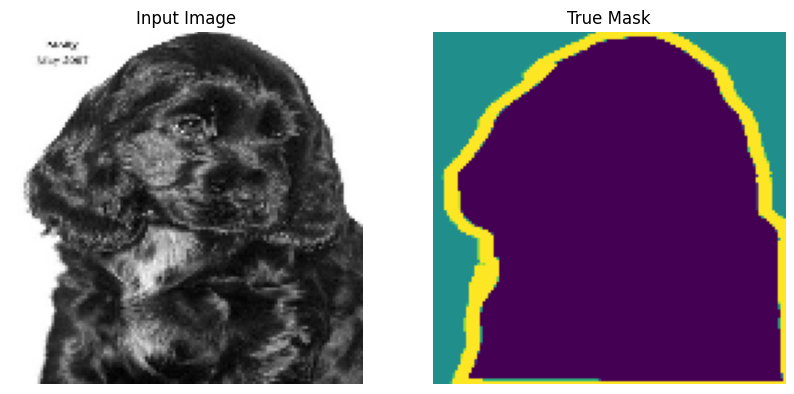

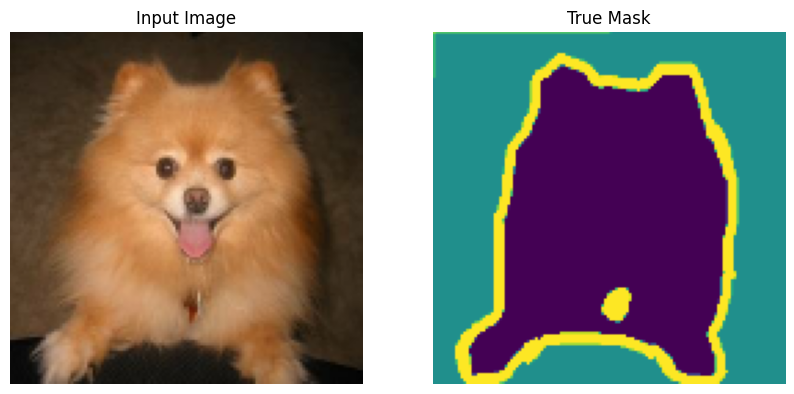

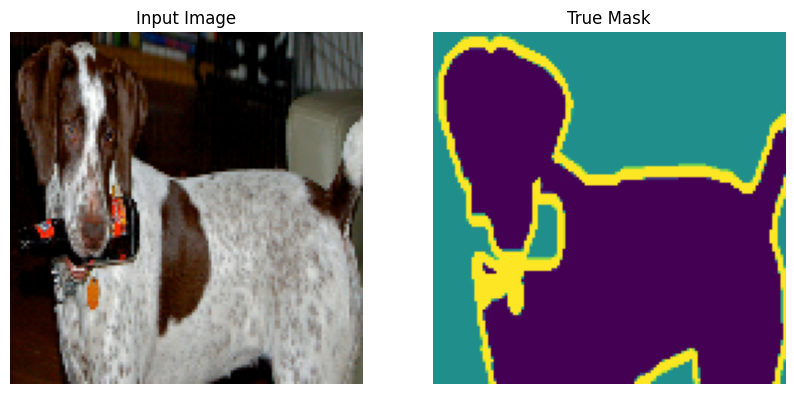

In [10]:
for images, masks in train_dataset.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

## Define U-Net Model

In [11]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [12]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # intermediate block
    intermediate_block = double_conv_block(p4, 1024)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

In [13]:
# for images, masks in train_dataset.take(1):
#     sample_image, sample_mask = images[0], masks[0]
# sample_mask[60]

In [14]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
!pip install pydot graphviz
!apt-get install -y graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


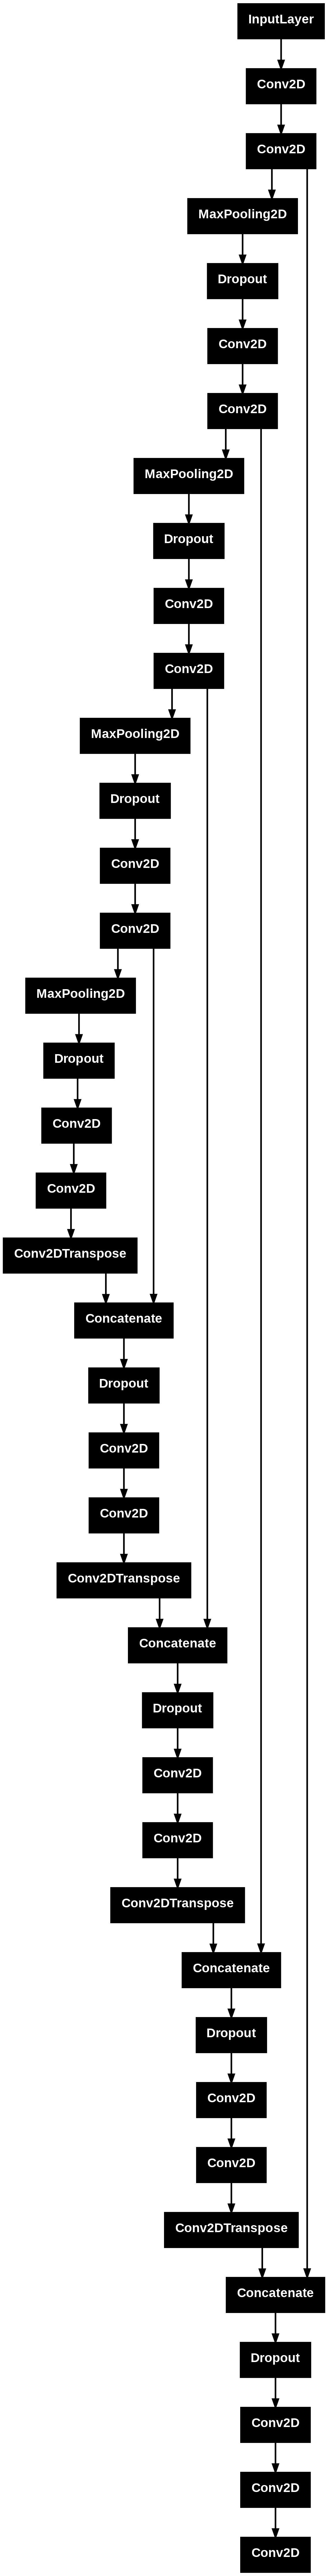

In [37]:
# plot the model
tf.keras.utils.plot_model(model, expand_nested=False)



## Train the Model

In [27]:
EPOCHS = 20
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=test_dataset)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.5523 - loss: 0.9724 - val_accuracy: 0.5730 - val_loss: 0.8719
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5896 - loss: 0.8204 - val_accuracy: 0.6704 - val_loss: 0.7278
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7120 - loss: 0.6753 - val_accuracy: 0.7359 - val_loss: 0.6218
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7454 - loss: 0.6066 - val_accuracy: 0.7726 - val_loss: 0.5571
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7756 - loss: 0.5407 - val_accuracy: 0.7989 - val_loss: 0.4836
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8039 - loss: 0.4768 - val_accuracy: 0.8217 - val_loss: 0.4359
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8085 - loss: 0.4682 - val_accuracy: 0.8260 - val_loss: 0.4233
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8252 - loss: 0.4300 - val_accuracy: 0.8359 - val_los

## Visualize the Results

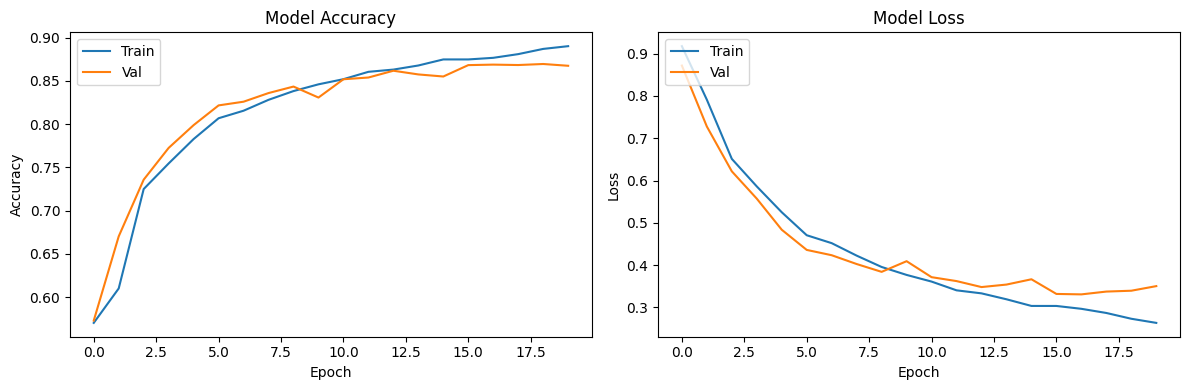

In [28]:
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

## Test Predictions

In [29]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])

In [33]:
for image, mask in test_dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    print(np.array(pred_mask.shape))
    pred_mask = pred_mask[..., tf.newaxis]
    print(pred_mask[0].shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
[ 64 128 128]
(128, 128, 1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step


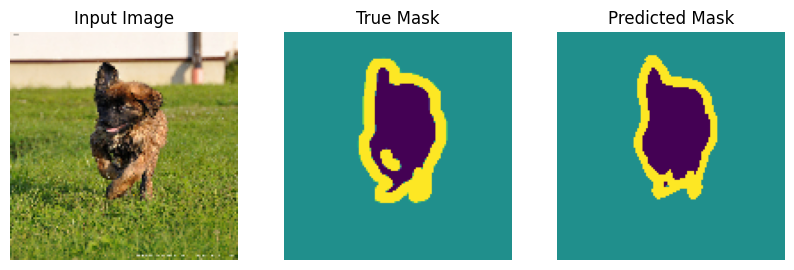

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


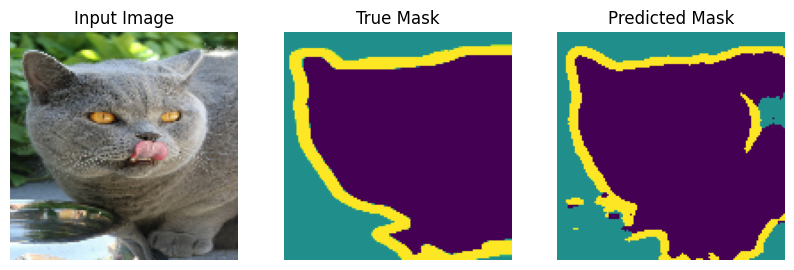

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


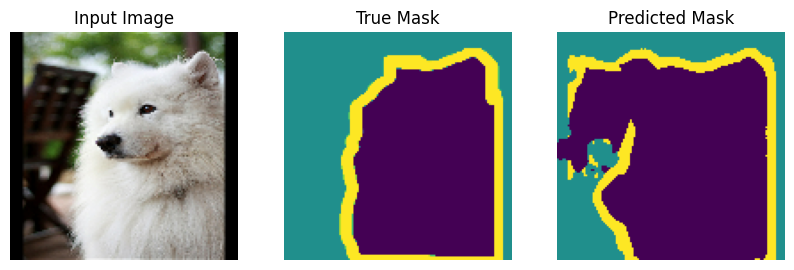

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


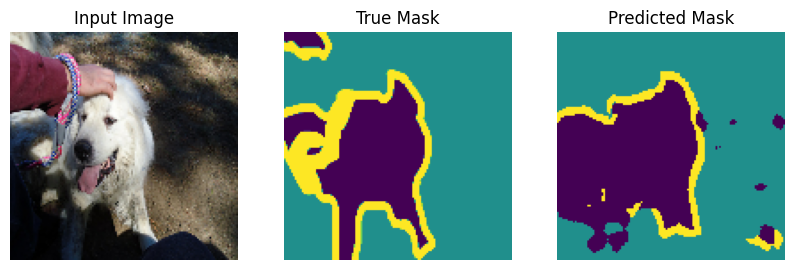

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


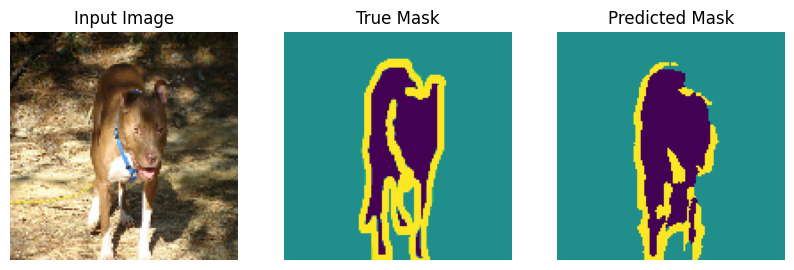

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


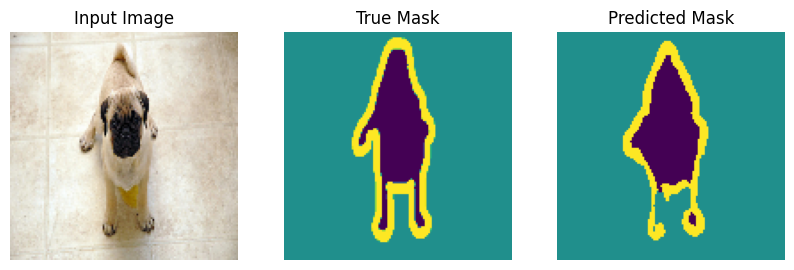

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


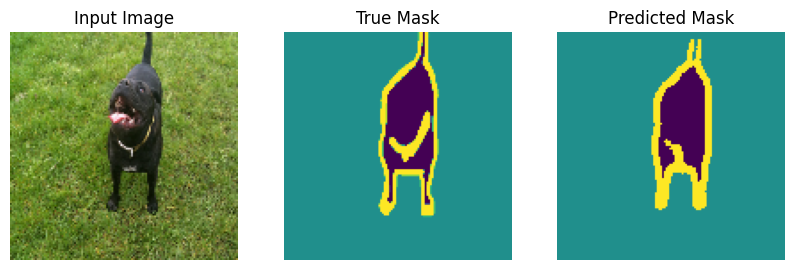

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


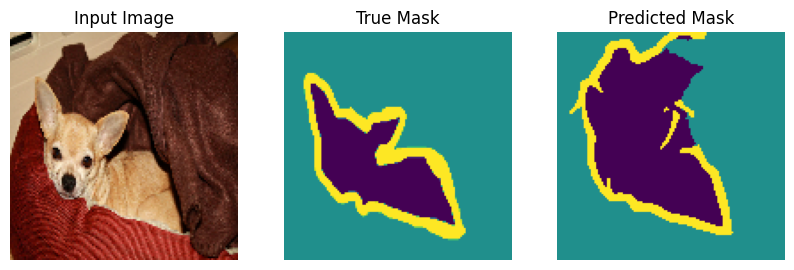

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


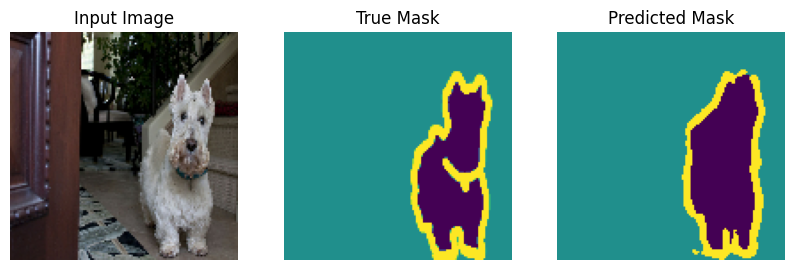

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


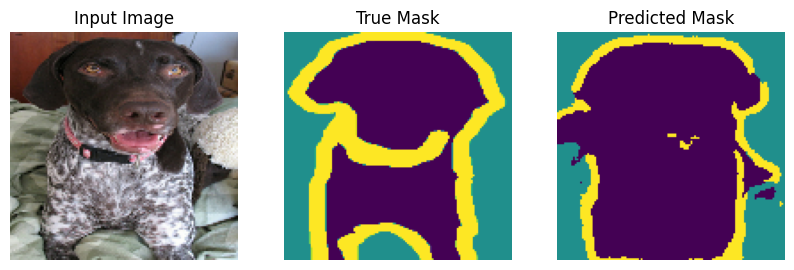

In [32]:
show_predictions(test_dataset, 10)